In [124]:
import numpy as np
import torch
from torchvision import transforms
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import TensorDataset
from torch.autograd import Variable 
torch.manual_seed(1)
np.random.seed(1)
import matplotlib.pyplot as plt

# For importing poses
import sys
import os
sys.path.append(os.path.expanduser("/workspace/code/pose-prediction/src/functions"))

In [125]:
from load_poses import get_poses_from_file
dataset_path = "/workspace/data/pose-prediction-odometry/tmp-testing/"
RO_se3s,RO_timestamps = get_poses_from_file(dataset_path)

Loading poses from monolithic file...
reading RO_relative_poses_path: /workspace/data/pose-prediction-odometry/tmp-testing/ro_relative_poses.monolithic
importing  protobuf.transform.pbSerialisedTransform_pb2
Finished reading 8421 poses.


In [126]:
# Crop poses - there was a dud pose at 6342, this is a quick fix for now
max_poses = 6000
RO_se3s = RO_se3s[:max_poses]
RO_timestamps = RO_timestamps[:max_poses]

train_test_ratio = 0.8
split_idx = int(len(RO_timestamps)*train_test_ratio)
train_RO_se3s = RO_se3s[:split_idx]
train_RO_timestamps = RO_timestamps[:split_idx]
test_RO_se3s = RO_se3s[split_idx:]
test_RO_timestamps = RO_timestamps[split_idx:]
print("Train set size:",len(train_RO_timestamps))
print("Test set size:",len(test_RO_timestamps))

Train set size: 4800
Test set size: 1200


In [127]:
t_x_data = np.zeros(len(train_RO_timestamps))
t_y_data = np.zeros(len(train_RO_timestamps))
t_theta_data = np.zeros(len(train_RO_timestamps))

for i in range(len(train_RO_timestamps)):
    t_x_data[i] = train_RO_se3s[i][0,3]
    t_y_data[i] = train_RO_se3s[i][1,3]
    t_theta_data[i] = np.arccos(train_RO_se3s[i][0,0])
    
test_t_x_data = np.zeros(len(test_RO_timestamps))
test_t_y_data = np.zeros(len(test_RO_timestamps))

for i in range(len(test_RO_timestamps)):
    test_t_x_data[i] = test_RO_se3s[i][0,3]
    test_t_y_data[i] = test_RO_se3s[i][1,3]

In [128]:
num_features = 2
num_frames = 2
input_size = num_features * num_frames
output_size = num_features

In [129]:
dim1_data = t_x_data
dim2_data = t_y_data

dim1_data_scaled = (dim1_data - dim1_data.mean())/dim1_data.std()
dim2_data_scaled = (dim2_data - dim2_data.mean())/dim2_data.std()

def prepare_data(dim1_data_scaled,dim2_data_scaled,train_validate_ratio,num_features,num_frames,input_size,output_size):
    """
    Data preparation - mock of the real function (just for x and y, no theta)
    
    For the two frame case, input tensor holds x, y, and theta data in frame 1, frame 2
    [x1,y1,th1,x2,y2,th2]
    These are offset, so that x1 goes up until the second last frame
    (current frame is treated as future prediction)

    Output tensor holds single frame, for x, y, and theta values
    This is cropped to exclude the first n frames (n=2 here) and run up until the end
    So a synthesised 'future' value to aim for

    """
    import torch
    from torch.utils.data.dataset import TensorDataset

    t_x = torch.tensor(dim1_data_scaled)
    t_y = torch.tensor(dim2_data_scaled)

    x_data = torch.zeros(len(dim1_data_scaled)-num_frames,input_size)
    start_idx = 0
    end_idx = len(x_data)
    frame_idx = num_frames - 1

    for i in range(num_frames):
#         x_data[:,frame_idx*num_features+2] = t_theta[start_idx:end_idx]
        x_data[:,frame_idx*num_features+1] = t_y[start_idx:end_idx]
        x_data[:,frame_idx*num_features] = t_x[start_idx:end_idx]
        start_idx+=1
        end_idx+=1
        frame_idx-=1 # older frames are assigned to later columns
    
    y_data = torch.zeros(len(dim1_data_scaled)-num_frames,output_size)
    y_data[:,0] = t_x[num_frames:]
    y_data[:,1] = t_y[num_frames:]
    
    x_rows = x_data.size()[0]
    training_idx_limit = int(train_validate_ratio * x_rows)

    x_train = x_data[:training_idx_limit,:]
    x_valid = x_data[training_idx_limit:,:]

    y_train = y_data[:training_idx_limit,:]
    y_valid = y_data[training_idx_limit:,:]

    print('x_data dimensions:',x_data.size())
    print('x_train dimensions:',x_train.size())
    print('x_valid dimensions:',x_valid.size())
    print('y_data dimensions:',y_data.size())
    print('y_train dimensions:',y_train.size())
    print('y_valid dimensions:',y_valid.size())
    
    train_ds = TensorDataset(x_train,y_train)
    valid_ds = TensorDataset(x_valid,y_valid)
    
    return train_ds, valid_ds

# from dataset_prep import prepare_data
train_validate_ratio = 0.8
train_ds,valid_ds = \
prepare_data(dim1_data_scaled,dim2_data_scaled, \
             train_validate_ratio,num_features,num_frames,input_size,output_size)

x_data dimensions: torch.Size([4798, 4])
x_train dimensions: torch.Size([3838, 4])
x_valid dimensions: torch.Size([960, 4])
y_data dimensions: torch.Size([4798, 2])
y_train dimensions: torch.Size([3838, 2])
y_valid dimensions: torch.Size([960, 2])


In [130]:
test_dim1_data = test_t_x_data
test_dim2_data = test_t_y_data

# We won't have access to mean and std of the test data, so must use the training set mean and std to do scaling
test_dim1_data_scaled = (test_dim1_data - dim1_data.mean())/dim1_data.std()
test_dim2_data_scaled = (test_dim2_data - dim2_data.mean())/dim2_data.std()

def prepare_test_data(test_dim1_data_scaled,test_dim2_data_scaled,num_features,num_frames,input_size,output_size):
    """
    Data preparation for test data

    """
    import torch
    from torch.utils.data.dataset import TensorDataset

    t_x = torch.tensor(test_dim1_data_scaled)
    t_y = torch.tensor(test_dim2_data_scaled)

    x_test = torch.zeros(len(test_dim1_data_scaled)-num_frames,input_size)
    start_idx = 0
    end_idx = len(x_test)
    frame_idx = num_frames - 1

    for i in range(num_frames):
        x_test[:,frame_idx*num_features+1] = t_y[start_idx:end_idx]
        x_test[:,frame_idx*num_features] = t_x[start_idx:end_idx]
        start_idx+=1
        end_idx+=1
        frame_idx-=1 # older frames are assigned to later columns

    y_test = torch.zeros(len(test_dim1_data_scaled)-num_frames,output_size)
    y_test[:,0] = t_x[num_frames:]
    y_test[:,1] = t_y[num_frames:]

    print('x_test dimensions:',x_test.size())
    print('y_test dimensions:',y_test.size())
    
    test_ds = TensorDataset(x_test,y_test)
    
    return test_ds

test_ds = prepare_test_data(test_dim1_data_scaled,test_dim2_data_scaled,num_features,num_frames,input_size,output_size)

x_test dimensions: torch.Size([1198, 4])
y_test dimensions: torch.Size([1198, 2])


In [131]:
import torch.nn as nn
#our class must extend nn.Module
class BiggerNetwork(nn.Module):
    def __init__(self):
        super(BiggerNetwork,self).__init__()
        #Our network consists of 3 layers. 1 input, 1 hidden and 1 output layer
        #This applies Linear transformation to input data. 
        self.fc1 = nn.Linear(input_size,3)
        
        #This applies linear transformation to produce output data
        self.fc2 = nn.Linear(3,output_size)
        
    #This must be implemented
    def forward(self,x):
        #Output of the first layer
        x = self.fc1(x)
        #Activation function is Relu. Feel free to experiment with this
        x = torch.relu(x) # F.tanh(x)
        #This produces output
        x = self.fc2(x)
        return x    
    
class SimpleNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(input_size,output_size)

    def forward(self, xb):
        return self.lin(xb)

In [132]:
from network_helpers import *

def loss_batch_tmp(model,loss_func,xb,yb,opt=None):    
    loss=loss_func(model(xb),yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(),len(xb)

def fit_tmp(epochs, model, loss_func, opt, train_dl, valid_dl):
    validation_loss = []
    train_loss = []
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            losses,nums = loss_batch_tmp(model, loss_func, xb, yb, opt)
            loss_in_training = np.sum(np.multiply(losses, nums)) / np.sum(nums)
            train_loss.append(loss_in_training)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch_tmp(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        validation_loss.append(val_loss)
        print(epoch, val_loss)
    return train_loss,validation_loss

batch_size = 30
epochs = 100
train_dl, valid_dl = get_data(train_ds, valid_ds, batch_size)
model = BiggerNetwork() #SimpleNetwork()
loss_func = nn.MSELoss() #nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
train_loss,validation_loss = fit_tmp(epochs, model, loss_func, optimizer, train_dl, valid_dl)


0 0.2831235392950475
1 0.2750483765557874
2 0.2764904706564266
3 0.2783789755048929
4 0.2758290096244309
5 0.2850777706480585
6 0.2977069425396621
7 0.29073914856417105
8 0.29583338694646955
9 0.28460434181033634
10 0.27658073141356
11 0.27914815113763325
12 0.2852196896565147
13 0.27770200339728035
14 0.2789159308304079
15 0.2832756509305909
16 0.274107557721436
17 0.27582935709506273
18 0.2828854783147108
19 0.2805885381239932
20 0.27989458991214633
21 0.2763073461537715
22 0.27751479868311435
23 0.30586594258784316
24 0.2735870554461144
25 0.2890388797968626
26 0.27790394975454547
27 0.2828235110209789
28 0.27579741581575945
29 0.2753436451894231
30 0.28842302632983774
31 0.2748509999655653
32 0.27437228930648416
33 0.28256637701997533
34 0.27156303499941714
35 0.2720011936035007
36 0.28142374721937813
37 0.2743884813389741
38 0.2876993056270294
39 0.29014042142080143
40 0.27179856289876625
41 0.274595672468422
42 0.27504260768182576
43 0.2747416474740021
44 0.2726592277176678
45 0.

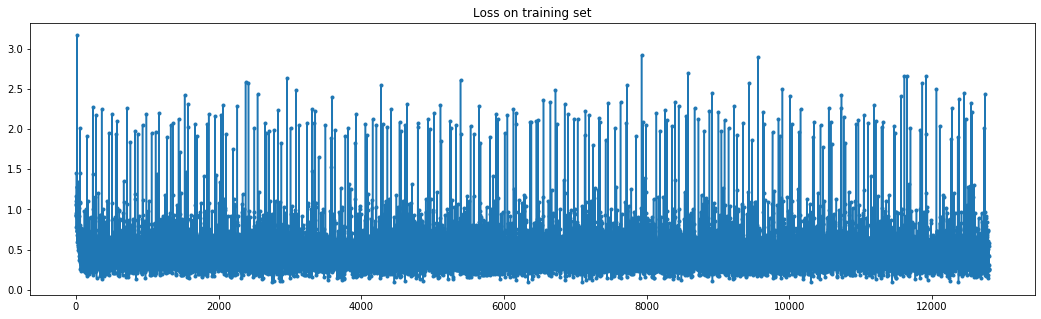

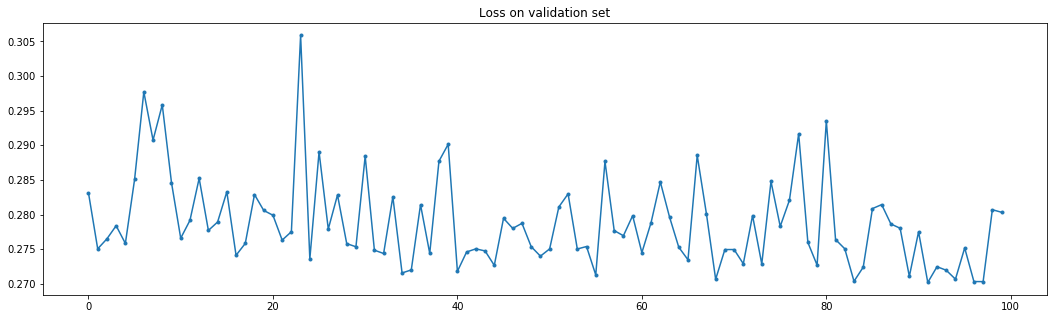

In [133]:
plt.figure(figsize=(18,5))
plt.title("Loss on training set")
plt.plot(train_loss,'.-')
plt.figure(figsize=(18,5))
plt.title("Loss on validation set")
plt.plot(validation_loss,'.-')

torch.Size([3838, 4]) torch.Size([3838, 2])


Text(0.5, 1.0, 'Pose in y direction for training set')

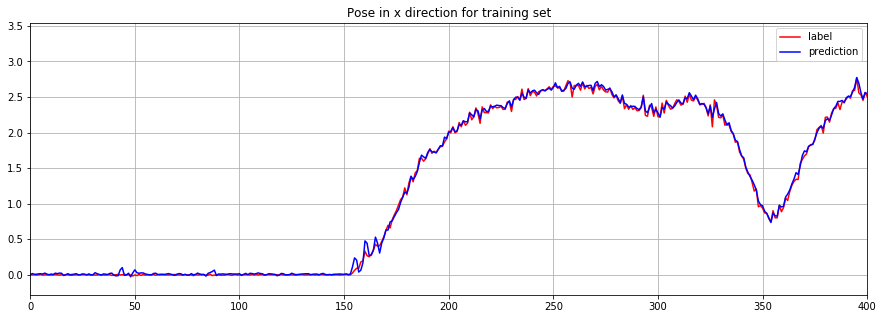

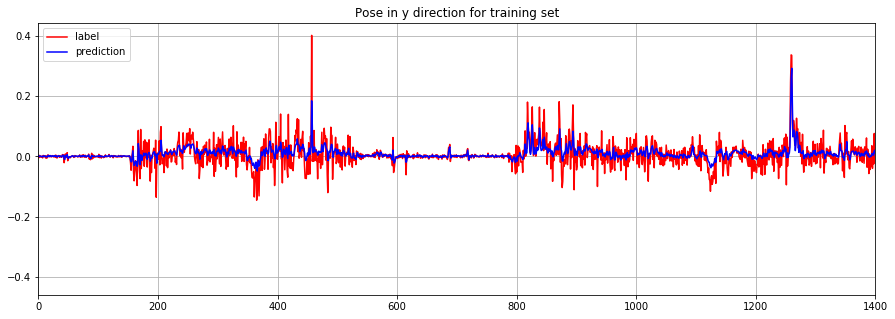

In [134]:
train_data_loader = DataLoader(dataset=train_ds,
                                     batch_size=len(train_ds),
                                     shuffle=False,
                                     num_workers=1)
    
batch_x, batch_y = next(iter(train_data_loader))
prediction = model(batch_x).data
print(batch_x.shape, batch_y.shape)

rescaled_gt_x = batch_y[:,0]*dim1_data.std() + dim1_data.mean()
rescaled_prediction_x = prediction[:,0]*dim1_data.std() + dim1_data.mean()
rescaled_gt_y = batch_y[:,1]*dim2_data.std() + dim2_data.mean()
rescaled_prediction_y = prediction[:,1]*dim2_data.std() + dim2_data.mean()

plt.figure(figsize=(15,5))
plt.plot(rescaled_gt_x,'r',label="label")
plt.plot(rescaled_prediction_x[1:],'b',label="prediction")
plt.grid()
plt.legend()
plt.xlim(0,400)
plt.title("Pose in x direction for training set")

plt.figure(figsize=(15,5))
plt.plot(rescaled_gt_y,'r',label="label")
plt.plot(rescaled_prediction_y[1:],'b',label="prediction")
plt.grid()
plt.legend()
plt.xlim(0,1400)
plt.title("Pose in y direction for training set")

torch.Size([960, 4]) torch.Size([960, 2])


Text(0.5, 1.0, 'Pose in y direction for validation set')

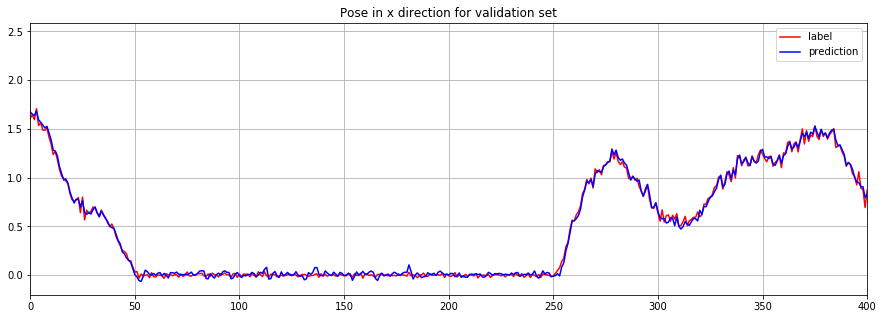

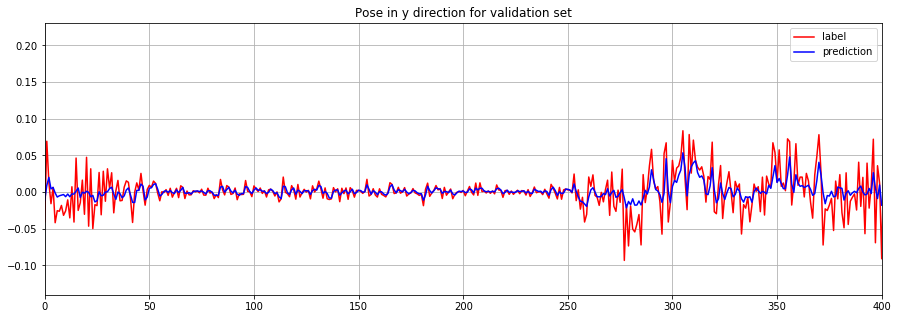

In [135]:
valid_data_loader = DataLoader(dataset=valid_ds,
                                     batch_size=len(valid_ds),
                                     shuffle=False,
                                     num_workers=1)
    
batch_x, batch_y = next(iter(valid_data_loader))
prediction = model(batch_x).data
print(batch_x.shape, batch_y.shape)

rescaled_gt_x = batch_y[:,0]*dim1_data.std() + dim1_data.mean()
rescaled_prediction_x = prediction[:,0]*dim1_data.std() + dim1_data.mean()
rescaled_gt_y = batch_y[:,1]*dim2_data.std() + dim2_data.mean()
rescaled_prediction_y = prediction[:,1]*dim2_data.std() + dim2_data.mean()

plt.figure(figsize=(15,5))
plt.plot(rescaled_gt_x,'r',label="label")
plt.plot(rescaled_prediction_x[1:],'b',label="prediction")
plt.grid()
plt.legend()
plt.xlim(0,400)
plt.title("Pose in x direction for validation set")

plt.figure(figsize=(15,5))
plt.plot(rescaled_gt_y,'r',label="label")
plt.plot(rescaled_prediction_y[1:],'b',label="prediction")
plt.grid()
plt.legend()
plt.xlim(0,400)
plt.title("Pose in y direction for validation set")

torch.Size([1198, 4]) torch.Size([1198, 2])


Text(0.5, 1.0, 'Pose in y direction for test set')

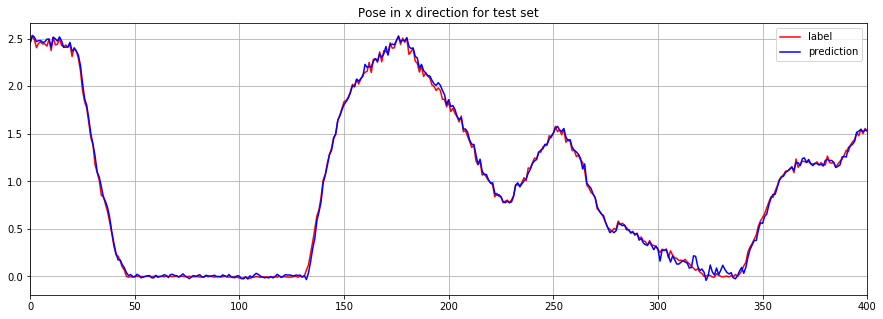

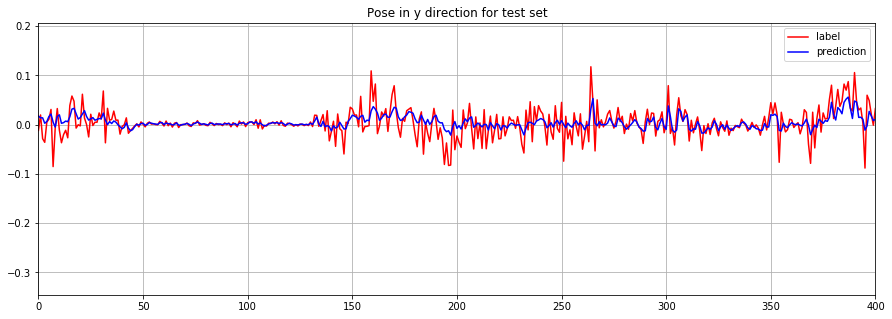

In [136]:
test_data_loader = DataLoader(dataset=test_ds,
                                     batch_size=len(test_ds),
                                     shuffle=False,
                                     num_workers=1)
    
batch_x, batch_y = next(iter(test_data_loader))
prediction = model(batch_x).data
print(batch_x.shape, batch_y.shape)

rescaled_gt_x = batch_y[:,0]*dim1_data.std() + dim1_data.mean()
rescaled_prediction_x = prediction[:,0]*dim1_data.std() + dim1_data.mean()
rescaled_gt_y = batch_y[:,1]*dim2_data.std() + dim2_data.mean()
rescaled_prediction_y = prediction[:,1]*dim2_data.std() + dim2_data.mean()

plt.figure(figsize=(15,5))
plt.plot(rescaled_gt_x,'r',label="label")
plt.plot(rescaled_prediction_x[1:],'b',label="prediction")
plt.grid()
plt.legend()
plt.xlim(0,400)
plt.title("Pose in x direction for test set")

plt.figure(figsize=(15,5))
plt.plot(rescaled_gt_y,'r',label="label")
plt.plot(rescaled_prediction_y[1:],'b',label="prediction")
plt.grid()
plt.legend()
plt.xlim(0,400)
plt.title("Pose in y direction for test set")